# Cuaderno de análisis de series temporales

Empezamos por cargar las librerías.  
Hay una librería muy adecuada para trabajar con series temporales: el módulo signal de scipy.

Para la función de autocorrelación, podéis usar también la librería statsmodels.   
Para instalarla con anaconda:  
> conda install -c conda-forge statsmodels

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa import stattools 
from netCDF4 import Dataset
from scipy import stats
from scipy import signal
from scipy.fft import fft 

Definimos funciones que usaremos

In [2]:
def runningMean(x,T):
    y = x.copy() * np.NaN
    N = x.size
    ini = int((T-1)/2)
    fin = int(T/2)
    for i in range(ini,N-fin):
        y[i] = np.mean(x[i-ini:i+fin+1])
    return y


def espectroArmonico(x,At):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( a**2+b**2 ) / 2
    f = kvec/(N*At)
    return f,G

def espectroFFT(x,At):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    # Habría que dividir entre 4, pero como sólo damos la parte positiva, para
    # que la suma de G nos aporte la varianza dividimos sólo entre 2
    G = ( ap**2+bp**2 ) / 2
    f = kvec/(N*At)
    return f,G

def redSpectra(a,s2):
    f = np.arange(.0,.51,.01)
    N = f.size
    G = (s2*(1-a**2))/(1+a**2-2*a*np.cos(2*np.pi*f))
    #Hay que multiplicar por 2 porque sólo sacamos la parte positiva
    return f,2*G

def ajusteArmonico(x,numArm):
    x = np.squeeze(np.array(x))
    N = x.size 
    xm = x.mean()
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    jvec=np.arange(1,N+1)
    a = np.zeros(Nmax)
    b = np.zeros(Nmax)
    xa = x-xm
    fac = 2*np.pi*jvec/N
    for k in range(Nmax):
        a[k] = 2 / N * np.sum( np.matmul(xa,np.cos(fac*(k+1)) ))
        b[k] = 2 / N * np.sum( np.matmul(xa,np.sin(fac*(k+1)) ))
    if (N%2)==0: b[Nmax-1]=0
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( a[:n] * np.cos (2*np.pi*kvec[:n]*(j+1)/N) + b[:n] *
                               np.sin (2*np.pi*kvec[:n]*(j+1)/N) )
    return xhat,a,b

def ajusteArmonicoFFT(x,numArm):
    x = np.squeeze(np.array(x))
    N=x.size
    Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
    y = fft(x)
    ap = 2/N*np.real(y[1:Nmax+1])
    bp =  - 2/N*np.imag(y[1:Nmax+1])
    xm = np.mean(x)
    kvec = np.arange(1,Nmax+1)
    xhat = np.zeros(N)
    n = np.min([numArm+1,Nmax])
    for j in range(N):
        xhat[j] =  xm + np.sum( ap[:n] * np.cos (2*np.pi*kvec[:n]*(j)/N) + bp[:n] * 
                               np.sin (2*np.pi*kvec[:n]*(j)/N) )
    return xhat,ap,bp

def calculoAR1(x):
    xm = np.mean(x)
    N = x.size
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    a = cor[1]
    sx = np.std(x, ddof=1)
    fac = np.sqrt((N-1)/(N-2)*(1-a**2))*sx
    AR1 = x * np.NaN
    rng = np.random.default_rng()
    Z = rng.normal(0,1,N)
    #También podéis generar el ruido blanco con stats de scipy
    #Z = stats.norm.rvs(size=N)
    AR1[0] = Z[0]
    for i in range(N-1):
        AR1[i+1] =  a * ( AR1[i] ) + fac * Z[i+1]
    return AR1 + xm


def calculoAutocov(x,nlag):
    cov = np.zeros([nlag+1])
    N = x.size
    xm = np.mean(x)
    ax = x-xm
    for t in range(nlag+1):
        cov[t] = np.sum(ax[:N-t]*ax[t:])/(N-1)
    return cov

def region(sst,lonmin, lonmax, latmin, latmax):
    reg = sst[:,:,(lon>lonmin)&(lon<lonmax)][:,(lat>latmin)&(lat<latmax),:].mean(axis=(1,2))
    nt = reg.size
    nm = 12
    ny = int(nt/nm)
    reg = reg.reshape(nm,ny,order='F')
    mreg = np.nanmean(reg,axis=1)
    anom = reg.copy()*np.NaN
    for i in range(ny):
        for j in range(nm):
            anom[j,i] = reg[j,i] - mreg[j]
    return anom

def readDataFrame(stationName):
    url = '../datos/isd/isd-history.csv'
    c=pd.read_csv(url)

    #Seleccionamos los años de inicio y final de lectura
    yearInit = 1990
    yearEnd = 2020

    #Construimos el código que necesitamos para bajar los datos de la estación:
    station=str(c.loc[(c['STATION NAME']==stationName)]['USAF'].values[0]) + '-' + \
            str(c.loc[(c['STATION NAME']==stationName)]['WBAN'].values[0])
    print('Seleccionada la estacion ' + stationName + ' con código ' + station)

    #Definimos las columnas y el tipo de dato que va a tener el DataFrame donde vamos a alojar los datos de la estación
    colNames=['year','month','day','hour','temp','tempd','slp','windDir','windSpeed','cloud','pcp1h','pcp6h']
    dataType=['int','int','int','int','float','float','int','int','int','int','int','int',]

    #Definimos los límites de los caractéres donde están los datos en los archivos que vamos a leer 
    #(Esta información está en: https://www.ncei.noaa.gov/pub/data/noaa/isd-lite/isd-lite-format.txt)
    limits=[(0,4),(5,7),(8,10),(11,13),(14,19),(20,25),(26,31),(32,37),(38,43),(44,49),(50,55),(56,61)]
    
    #Lectura de los datos:
    df=pd.DataFrame(columns=colNames)
    for iyr in range(yearInit, yearEnd, 1):
        fil='../datos/isd/'+station+'-'+str(iyr)+'.gz'
        data= pd.read_fwf(fil,sep=' ',compression='gzip',head=0,
                     names=colNames,colspecs=limits)
        df = df.append(data)

    #Cambio el tipo de dato (porque los lee como objetos str y queremos que sean numéricos)
    dictType={ colNames[i] : dataType[i] for i in range(12)}
    data = df.astype(dictType,copy=True)
    #Los datos missing son -9999 en la base de datos: cambiamos por NaN:
    data = data.replace(-9999,np.NaN)
    
    dataDailyMax = data.groupby(['year','month','day']).max().drop(['hour'],axis=1).reset_index()
    dataDailyMax['time'] = pd.to_datetime(dataDailyMax[['year','month','day']],yearfirst=True)
    dataDailyMax = dataDailyMax.set_index('time')

    dataDailyCum = data.groupby(['year','month','day']).sum().drop(['hour'],axis=1).reset_index()
    dataDailyCum['time'] = pd.to_datetime(dataDailyCum[['year','month','day']],yearfirst=True)
    dataDailyCum = dataDailyCum.set_index('time')
    
    
    return dataDailyMax, dataDailyCum


## Ejemplos de series con memoria

### 1. Temperatura diaria: Barajas en marzo

In [3]:
dataDailyMax, dataDailyCum = readDataFrame('BARAJAS')
tMar = np.array(dataDailyMax[dataDailyMax['month']==3]['temp']/10)

Seleccionada la estacion BARAJAS con código 082210-99999


Text(0, 0.5, 'tmax (ºC)')

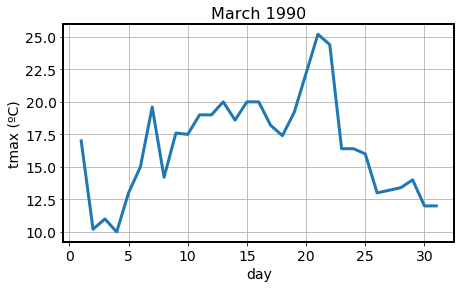

In [4]:
parameters = {'xtick.labelsize':14,
              'ytick.labelsize':14,
              'axes.labelsize':14,
              'axes.linewidth':2}
plt.rcParams.update(parameters)


nd , ny = 31, 30
tMar = np.reshape(tMar,(nd,ny),order='F')
#Pintamos marzo
fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(np.arange(1,32),tMar[:,0],linewidth=3)
ax.grid()
ax.set_xlabel('day',fontsize=14)
ax.set_title('March 1990',fontsize=16)
ax.set_ylabel('tmax (ºC)',fontsize=14)

Text(0, 0.5, '$T_{n+1}$')

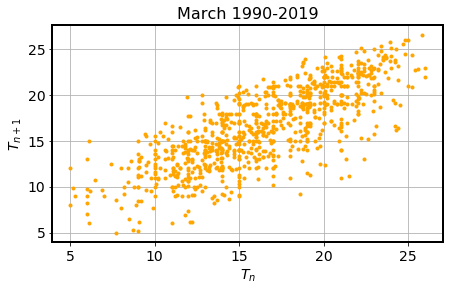

In [5]:
fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(np.reshape(tMar[0:-1,:],((nd-1)*ny,1),order='F'),
        np.reshape(tMar[1:,:],((nd-1)*ny,1),order='F'),'.',color='orange')
ax.grid()
ax.set_xlabel(r'$T_n$',fontsize=14)
ax.set_title('March 1990-2019',fontsize=16)
ax.set_ylabel(r'$T_{n+1}$',fontsize=14)

### 2. Temperaturas de la superficie del mar en el Pacífico

In [6]:
fil = Dataset('../datos/HadISST1/HadISST1_sst_1870-2019.nc')
variables = fil.variables
lon = variables['longitude'][:]
lat = variables['latitude'][:]
sst = variables['sst'][:]
nt, nlat, nlon = sst.shape
nm = 12
ny = int(nt/nm)


anom = region(sst,-170, -90, -5, 5)
nm, ny = anom.shape
anom = np.reshape(anom,(nm*ny,1),order='F')
time = np.arange(1870,2019+11/12,1/12)

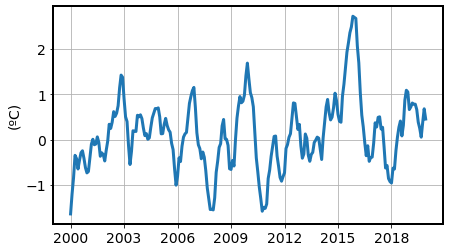

In [7]:
L = -240 #Pintamos los últimos 240 valores (20 años)

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(time[L:],anom[L:],linewidth=3)
ax.set_ylabel('(ºC)')
ax.set_xticks(np.arange(2000,2020,3))
ax.grid()


## Dominio del tiempo

### Autocovarianza y autocorrelación

Veamos cómo es la memoria de la serie de los datos de marzo. Cuidado que hemos de ir perdiendo datos a los lados 

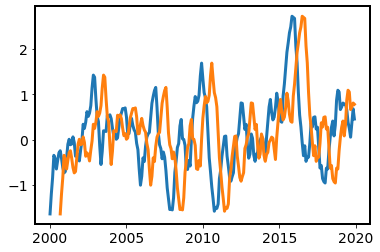

In [8]:
plt.plot(time[L:],anom[L:],linewidth=3)

#Desplazamos j pasos y vemos si se parecen:
j = 8
plt.plot(time[L+j:],anom[L:-j],linewidth=3)


Text(0, 0.5, '$T_{n+\\tau}$')

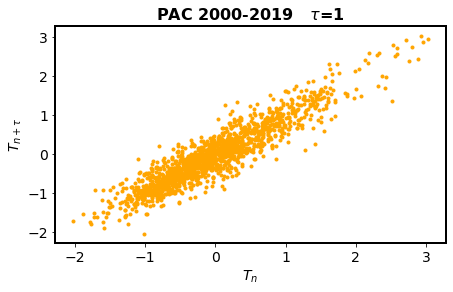

In [9]:
#Enfrentamos la serie original a sí misma desplazada j pasos:
j = 1
fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(anom[0:L-j],anom[j:L],'.',color='orange')
ax.set_xlabel(r'$T_n$',fontsize=14)
ax.set_title(r'PAC 2000-2019   $\tau$='+str(j),fontsize=16, weight = 'bold')
ax.set_ylabel(r'$T_{n+\tau}$',fontsize=14)


## Autocovarianza y autocorrelación de series temporales

Para la autocovarianza, podemos usar la acovf de stattools o programar la nuestra.
Usemos el ejemplo anterior con la anomalía de la temperatura del Pacífico.

Usaremos más años que en el ejemplo anterior: toda la serie
Podemos usar acofvf de stattools de tsa de statsmodels o programar nuestra propia versión de la autocorrelación

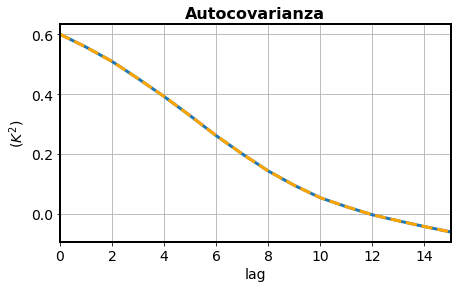

In [10]:
nlag = 15 #Número de lags para los que queremos calcular la autocovarianza

#Usando acovf (el coef N/(N-1) es para hacerlo consistente con la definición que hemos dado en los apuntes
# y que usamos en la función calculoAutocov)

N = anom.size
#Aquí usamos stattols.acovf
c = stattools.acovf(anom, fft=False, nlag = nlag) * N/(N-1)  #la funcion stTTOOLS. me calcula la autovarianza

#Aquí usamos nuestra propia función
cov = calculoAutocov(anom,nlag)

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(c,linewidth=3)
ax.plot(cov,'--',linewidth=3,color='orange')
ax.set_title('Autocovarianza', fontsize=16,weight='bold')
ax.set_ylabel(r'($K^2$)')
ax.set_xlabel('lag')
ax.set_xlim([0,nlag])
ax.grid()


### Podemos calcularlo también para otras series con "memoria" más larga como la que vimos del atlántico en la práctica 1

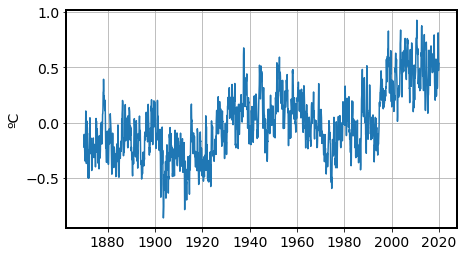

In [11]:
atl = region(sst, -70, 0, 0, 60)
atl = np.reshape(atl,(nm*ny,1),order='F')
fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(time,atl)
ax.set_ylabel('ºC')
ax.grid()

(0, 480)

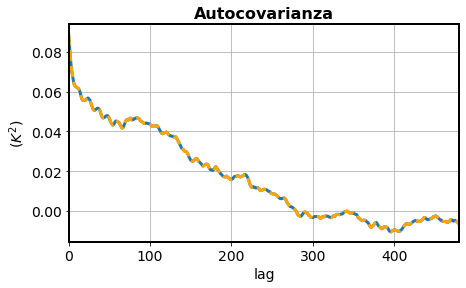

In [12]:
nlag = 40*12 #Número de lags para los que queremos calcular la autocovarianza

cAtl = stattools.acovf(atl, fft=False, nlag = nlag) * N/(N-1)

covAtl = calculoAutocov(atl,nlag)

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(cAtl,linewidth=3)
ax.plot(covAtl,'--',linewidth=3,color='orange')
ax.set_title('Autocovarianza', fontsize=16,weight='bold')
ax.set_ylabel(r'($K^2$)')
ax.set_xlabel('lag')
ax.grid()
ax.set_xlim([0,nlag])



### Para la autocorrelación:
* podemos usar la autocovarianza y dividir entre la desviación típica
* podemos usar la función acf de stattools de tsa de statsmodels
* podemos programarlo nosotros mismos

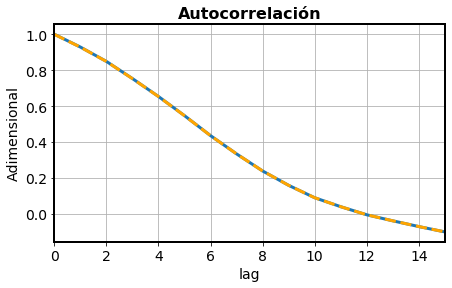

In [13]:
nlag = 15 #Número de lags para los que queremos calcular la autocovarianza

#Usando acf (el coef N/(N-1) es para hacerlo consistente con la definición que hemos dado en los apuntes
# y que usamos en la función calculoAutocov)
co = stattools.acf(anom, fft=False, nlags = nlag) * N/(N-1)
cov = calculoAutocov(anom,nlag)
corr = cov/cov[0]

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(co,linewidth=3)
ax.plot(corr,'--',linewidth=3,color='orange')
ax.set_title('Autocorrelación', fontsize=16,weight='bold')
ax.set_ylabel('Adimensional')
ax.set_xlabel('lag')
ax.set_xlim([0,nlag])
ax.grid()



(0, 480)

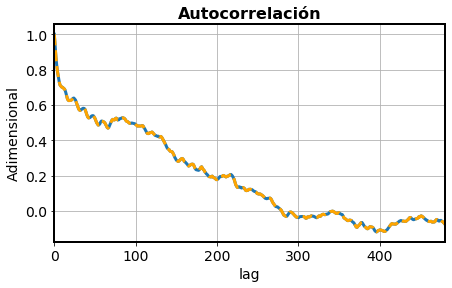

In [14]:
nlag = 40*12 #Número de lags para los que queremos calcular la autocovarianza

coAtl = stattools.acf(atl, fft=False, nlags = nlag) * N/(N-1)

covAtl = calculoAutocov(atl,nlag)
corrAtl = covAtl / covAtl[0]

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(coAtl,linewidth=3)
ax.plot(corrAtl,'--',linewidth=3,color='orange')
ax.set_title('Autocorrelación', fontsize=16,weight='bold')
ax.set_ylabel('Adimensional')
ax.set_xlabel('lag')
ax.grid()
ax.set_xlim([0,nlag])



### Veamos qué "memoria" tienen series obtenidas con la distribución normal (ruido blanco):

(0, 15)

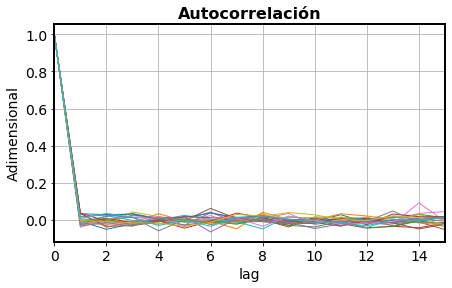

In [15]:
rng = np.random.default_rng()
mu, sigma = 0, 2
nlag = 15
#Las construyo tan largas como la de atl que trabajábamos
fig,ax = plt.subplots(1,1,figsize=(7,4))
for i in range(20):
    x1 = rng.normal(mu,sigma,atl.size)
    cox1 = stattools.acf(x1, fft=False, nlags = nlag) * N/(N-1)
    ax.plot(cox1,linewidth=1)

ax.set_title('Autocorrelación', fontsize=16,weight='bold')
ax.set_ylabel('Adimensional')
ax.set_xlabel('lag')
ax.grid()
ax.set_xlim([0,nlag])

## Generemos ruido rojo con características similares a las del índice del Pacífico

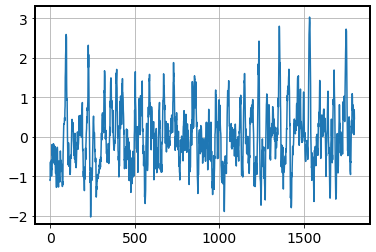

In [16]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(anom)
ax.set_ylim([-2.2 ,3.3])
ax.grid()

La varianza de la serie original y la muestra de AR es:  [0.6000301796412956, 0.570322638283214]


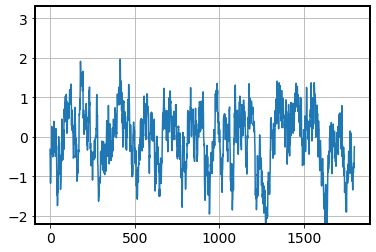

In [17]:
#Usamos la función calculoAR1 programada:
AR1 = calculoAR1(anom)
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(AR1)
ax.set_ylim([-2.2 ,3.3])
ax.grid()
print('La varianza de la serie original y la muestra de AR es: ',[np.var(anom),np.var(AR1)])


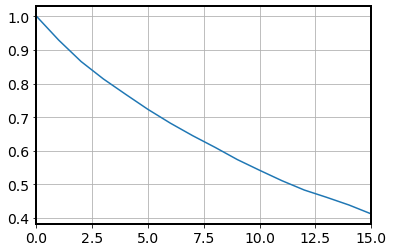

In [18]:
#Su autocovarianza es:
cox1 = stattools.acf(AR1, fft=False, nlags = nlag) * N/(N-1)
plt.plot(cox1)
plt.xlim([0,nlag])
plt.grid()

### Veamos la aplicación a las temperaturas diarias máximas de marzo en Bajaras

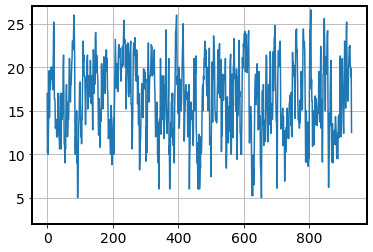

In [19]:
serie = np.reshape(tMar,(31*30,1),order='F')
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(serie)
ax.set_ylim([2 ,27])
ax.grid()

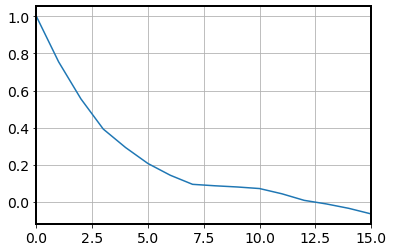

In [20]:
co = stattools.acf(serie, fft=False, nlags = nlag) * N/(N-1)
plt.plot(co)
plt.xlim([0,nlag])
plt.grid()

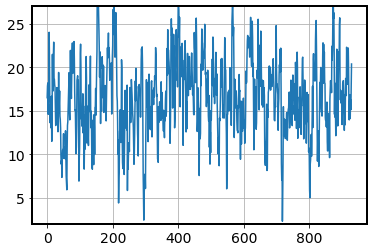

In [21]:
AR1_serie = calculoAR1(serie)
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(AR1_serie)
ax.set_ylim([2 ,27])
ax.grid()

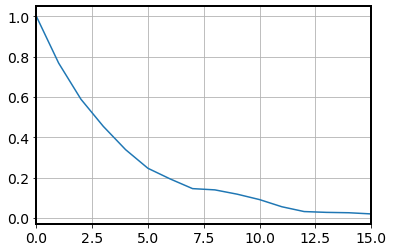

In [22]:
co = stattools.acf(AR1_serie, fft=False, nlags = nlag) * N/(N-1)
plt.plot(co)
plt.xlim([0,nlag])
plt.grid()


# Análisis armónico

Comencemos con una estimación rápida del ciclo estacional de la tmax diaria media mensual en Barajas:


0.2617993877991494

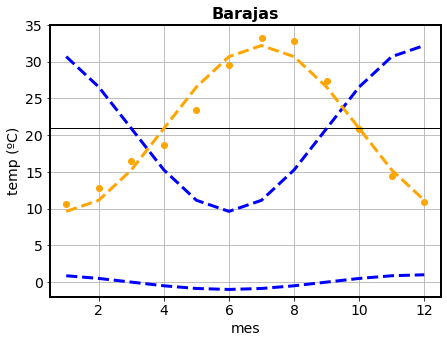

In [23]:
cicloEstacional = dataDailyMax.groupby(['month']).mean()['temp']/10
t = np.arange(1,13)
m = cicloEstacional.mean()
fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(t,cicloEstacional,'o',color='orange')
ax.plot([0.5,12.5],[m,m],'-',color='black',linewidth=1)
ax.set_xlim([0.5,12.5])
ax.set_ylim([-2,35])
ax.grid()
ax.set_title('Barajas',fontsize=16,weight='bold')
ax.set_xlabel('mes')
ax.set_ylabel('temp (ºC)')
c1 = (cicloEstacional.max()-cicloEstacional.min())/2
f1 = 1 / 12
y1 = np.cos(f1*t*2*np.pi)
ax.plot(t,y1,'--',color='blue',linewidth=3)
y2 = y1 * c1 + m
ax.plot(t,y2,'--',color='blue',linewidth=3)
fi1 = 7  * f1 * 2 * np.pi
y3 = m + c1 * np.cos(f1*t*2*np.pi-fi1)
ax.plot(t,y3,'--',color='orange',linewidth=3)
f1 * 6 /12 * 2 * np.pi

#### Hagamos un ajuste por mínimos cuadrados de los coeficientes para el modo fundamental

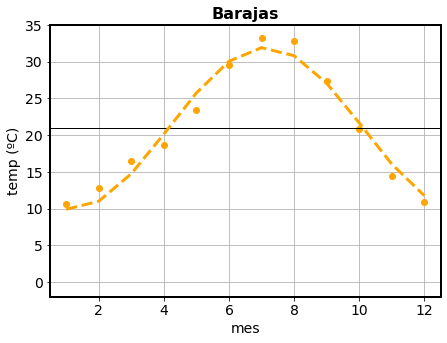

In [24]:
x = cicloEstacional
t = np.arange(1,13)
At = 1
xm = np.mean(x)
N = x.size
j=np.arange(1,13)
a1 = 2/N*np.sum((x-xm)*np.cos(2*np.pi*j/N/At))
b1 = 2/N*np.sum((x-xm)*np.sin(2*np.pi*j/N/At))
xArm = xm + a1 * np.cos(2*np.pi*j/N/At) + b1*np.sin(2*np.pi*j/N/At)

fig,ax = plt.subplots(1,1,figsize=(7,5))
ax.plot(t,x,'o',color='orange')
ax.plot([0.5,12.5],[m,m],'-',color='black',linewidth=1)
ax.set_xlim([0.5,12.5])
ax.set_ylim([-2,35])
ax.grid()
ax.set_title('Barajas',fontsize=16,weight='bold')
ax.set_xlabel('mes')
ax.set_ylabel('temp (ºC)')
ax.plot(t,xArm,'--',color='orange',linewidth=3)

## Veamos otro ejemplo: días lluviosos en Barajas, promedio de los 30 años
## Aquí usaremos más armónicos

(0, 365)

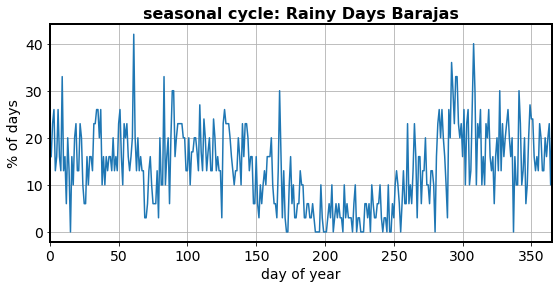

In [25]:
rain = dataDailyCum.groupby(['year','month','day']).mean()['pcp6h'].reset_index()
rainyDays = rain[rain['pcp6h']>0].groupby(['month','day']).count()[['pcp6h']].reset_index()
totalDays = rain.groupby(['month','day']).count()[['pcp6h']].reset_index()
rainyDays['frec'] = rainyDays['pcp6h']/totalDays['pcp6h'] * 100
rainyDays['year'] =1990
rainyDays['time'] = pd.to_datetime(rainyDays[['year','month','day']],unit='D')
rainyDays['dayOfYear'] = rainyDays['time'].dt.dayofyear

#Hay días sin lluvia:
day = np.arange(1,366)
rDay = 0*day
rDay[np.array(rainyDays['dayOfYear']-1)]=np.array(rainyDays['frec'])

fig,ax = plt.subplots(1,1,figsize=(9,4))
ax.plot(day,rDay)
ax.grid()
ax.set_ylabel('% of days')
ax.set_xlabel('day of year')
ax.set_title('seasonal cycle: Rainy Days Barajas', fontsize=16,weight='bold')
ax.set_xlim([0,365])


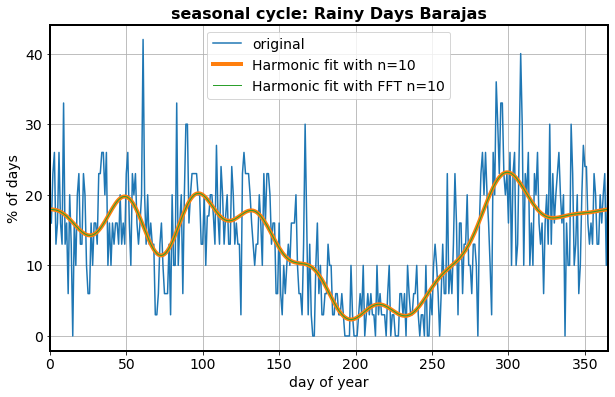

In [26]:
x =rDay
t = day
#En nArm ponemos el número de armónicos que queremos usar para la reconstricción
#nArm = int((x.size-1)/2)
nArm = 10

#Probamos reconstruir con el ajuste armónico y también con FFT:
rDayHat,a,b = ajusteArmonico(x,nArm) 
rDayHat2,a2,b2 = ajusteArmonico(x,nArm)
fig,ax = plt.subplots(1,1,figsize=(10,6))
ax.plot(t,x,label='original')
ax.plot(t,rDayHat,label='Harmonic fit with n='+str(nArm),linewidth=4)
ax.plot(t,rDayHat2,label='Harmonic fit with FFT n='+str(nArm),linewidth=1)
ax.grid()
ax.legend(fontsize=14)
ax.set_ylabel('% of days')
ax.set_xlabel('day of year')
ax.set_title('seasonal cycle: Rainy Days Barajas', fontsize=16,weight='bold')
ax.set_xlim([0,365]);

# Análisis espectral

## Veamos el espectro de un proceso autoregresivo de primer orden, AR(1):

Text(0, 0.5, '$\\Gamma(f)$')

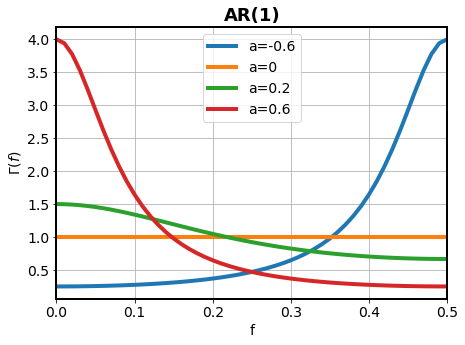

In [27]:
fig,ax = plt.subplots(1,1,figsize=(7,5))
s2 = 1
for a in [ -0.6, 0 , 0.2, 0.6 ] :
    f,G = redSpectra(a,s2)
    ax.plot(f,G/2, linewidth=4,label='a='+str(a))
    #Divido entre 2 para representarlo normalizado en -0.5<=f<=0.5 
    #(en el resto de espectros están normalizados en '0<=f<=0.5 para que la suma de los coeficientes
    # sea igual que la varianza de la señal de origen')
ax.set_xlim([0, .5])
ax.grid()
ax.legend(fontsize=14)
ax.set_title('AR(1)',fontsize=18,weight='bold')
ax.set_xlabel('f')
ax.set_ylabel(r'$\Gamma(f)$')


## Veamos cómo usar FFT para obtener los coeficientes de la transformada de Fourier Discreta, y cómo usarlos para obtener el periodograma

En la siguiente celda se emplean dos funciones definidas arriba del todo que calculan el espectro de una señal de entrada.  
La primera calcula los coeficientes armónicos, mientras que la segunda emplea el algoritmo FFT

La varianza de la serie original, es  69.78712704072059
La integral del espectro ya sea calculado con ajuste mínimos cuadrados o FFT es  69.78712704072079 69.78712704072059


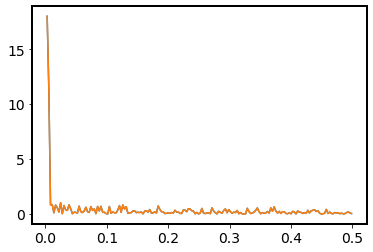

In [28]:
x = rDay
fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
plt.plot(fa,Ga)
plt.plot(ff,Gf)
print('La varianza de la serie original, es ',np.var(x))
print('La integral del espectro ya sea calculado con ajuste mínimos cuadrados o FFT es ',np.sum(Ga),np.sum(Gf))

### Calculemos el espectro de la serie de temperatura del Pacífico 

La varianza de la serie es  0.6000301796412956
La integral del espectro es  0.6000301796412963


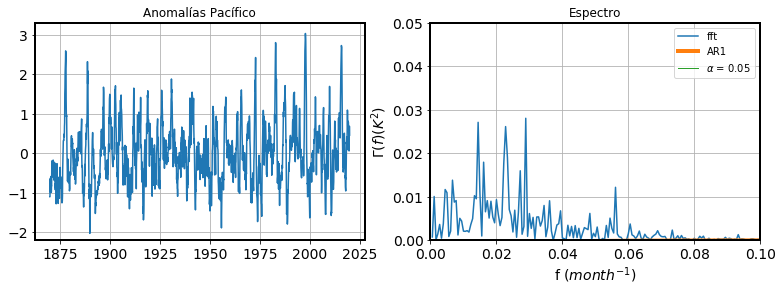

In [29]:
fig,ax=plt.subplots(1,2,figsize=(13,4))
ax[0].plot(time,anom)
ax[0].set_ylim([-2.2 ,3.3])
ax[0].grid()
ax[0].set_title('Anomalías Pacífico')

x = np.squeeze(np.array(anom))


#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=1)
ax[1].plot(ff,Gf,label='fft')
ax[1].grid()
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro')

print('La varianza de la serie es ',np.var(x))
print('La integral del espectro es ',sum(Gf))


#Veamos si los picos sobresalen lo suficiente:
alpha = 0.05
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
s2 = np.var(x)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha$ = 0.05')
a,s2,chi2
ax[1].set_ylim([0.,0.05])
ax[1].set_xlim([0,0.1])
ax[1].legend()



## Veamos el caso de la temperatura del Atlántico:

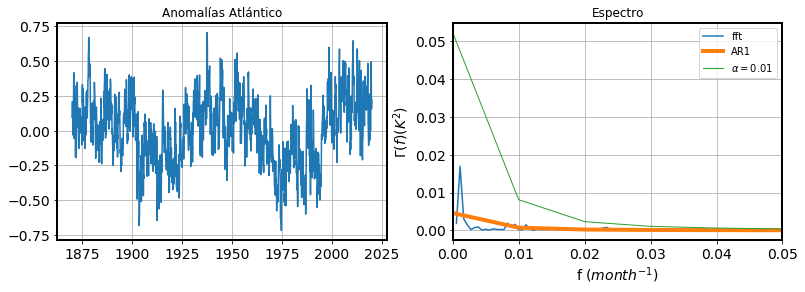

In [30]:
#Esta serie tiene mucha tendencia. Mejor quitarla para hacer la serie estacionaria:
x = signal.detrend(np.squeeze(np.array(atl)))
fig,ax=plt.subplots(1,2,figsize=(13,4))
ax[0].plot(time,x)
ax[0].grid()
ax[0].set_title('Anomalías Atlántico')
#fa,Ga = espectroArmonico(x,1)
ff,Gf = espectroFFT(x,1)
#ax[1].plot(fa,Ga,linewidth=4)
ax[1].plot(ff,Gf,label='fft')
ax[1].grid()
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($month^{-1}$)')
ax[1].set_title('Espectro')
[np.var(x),np.sum(Ga),np.sum(Gf)]

#Veamos si los picos sobresalen lo suficiente:
alpha = 0.01
alphaS = alpha / Gf.size
nu = 2
chi2 = stats.chi2.ppf(1-alphaS,2)
s2 = np.var(x)
cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
a = cor[1]
f,G = redSpectra(a,s2)
ax[1].plot(f,G/x.size,linewidth=4,label='AR1')
Gmax = G/x.size/nu*chi2
ax[1].plot(f,Gmax,linewidth=1,label=r'$\alpha = 0.01$')
a,s2,chi2
ax[1].set_xlim([0.,0.05])
ax[1].legend()
#ax[1].set_xlim([-0.0002,0.005])

## Veamos qué pasa si usamos el periodograma para calcular el espectro de varias muestras de ruido rojo

Tomemos como muestra las temperaturas máximas diarias en Barajas para el primer año:

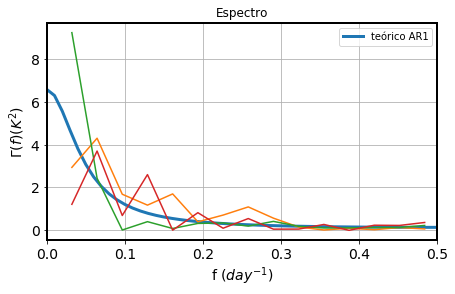

In [31]:
ny=30
tMar = np.reshape(np.array(tMar), (nd , ny ), order='F')
x = np.squeeze(tMar[:,0])
N = x.size
fig,ax=plt.subplots(1,1,figsize=(7,4))

cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
s2 = np.var(x)
a = cor[1]
f,G = redSpectra(a,s2)
Gp = G/N
ax.plot(f,Gp,linewidth=3,label='teórico AR1')
ny = 3
Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
Gfm = np.zeros([Nmax,ny])
for i in range(ny):
    AR1 = calculoAR1(x)
    ff,Gf = espectroFFT(AR1,1)
    Gfm[:,i]=Gf
    ax.plot(ff,Gf)

#ax.plot(ff,Gfm.mean(axis=1),label='Medias ruido rojo')


ax.grid()
ax.set_ylabel(r'$\Gamma(f) (K^2)$')
ax.set_xlabel(r'f ($day^{-1}$)')
ax.set_title('Espectro')
ax.set_xlim([0,0.5])
ax.legend()


### Calculemos el espectro de la serie de temperaturas máximas de marzo en Barajas
Aquí hay que tener cuidado porque hemos de separar los años entre sí. Vamos a aprovechar que tenemos 30 años
de datos para calcular 30 espectros diferentes y hacer el promedio para tener una estimación más robusta.

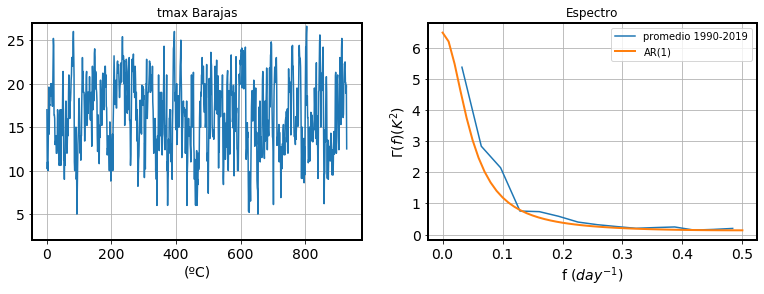

In [32]:
ny = 30
nd = 31
t = np.arange(1,nd+1)
serie = np.reshape(tMar,(nd*ny,1),order='F')
tMar = np.reshape(np.array(tMar), (nd, ny), order='F')
N = nd
Nmax = int(N/2) if (N % 2) == 0 else int((N-1)/2)
Gfm = np.zeros([Nmax,ny])
rho1 = 0.0
s2 = 0 
for i in range(ny):
    x = tMar[:,i]
    ff,Gf = espectroFFT(x,1)
    Gfm[:,i] = Gf
    cor = stattools.acf(x, fft=False, nlags = 1) * N/(N-1)
    rho1 = rho1 + cor[0]/ny
    s2 = s2 + np.var(x)/ny

Gf = Gfm.mean(axis=1)
z = np.arange(0,fa.size)

fig,ax=plt.subplots(1,2,figsize=(13,4))
ax[0].plot(serie)
ax[0].set_ylim([2 ,27])
ax[0].grid()
ax[0].set_title('tmax Barajas')
ax[0].set_xlabel('(ºC)')

ax[1].plot(ff,Gf,label='promedio 1990-2019')
ax[1].grid()
ax[1].set_ylabel(r'$\Gamma(f) (K^2)$')
ax[1].set_xlabel(r'f ($day^{-1}$)')
ax[1].set_title('Espectro')

f,G = redSpectra(a,s2)
Gp = G/N
ax[1].plot(f,Gp,linewidth=2,label='AR(1)')

ax[1].legend()

# Filtros
## Comencemos con la media móvil: su función de respuesta viene dada por
>  ## $ R(f)= \hat{b}(f) = \frac{\sin(\pi f T)}{\pi f T}=\text{sinc}(\pi fT)$  
NOTA: La función sinc de numpy ya tiene en cuenta el $\pi$: 
> np.sinc(x) es igual a $\frac{\sin(\pi x)}{\pi x}$

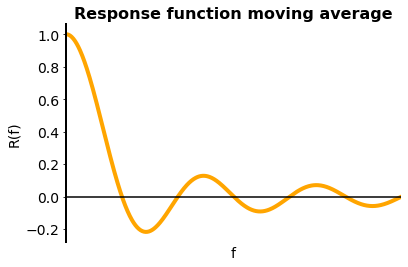

In [33]:
T = 1
f = np.arange(0,6,0.01)
R = np.sinc(f*T)

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(f,R,linewidth=4,color='orange')
ax.plot([f.min(),f.max()],[0,0],color='k')
#ax.grid()
ax.set_xlim([f.min(),f.max()])
ax.set_ylabel('R(f)')
ax.set_xlabel('f')
ax.set_title('Response function moving average',fontsize=16,weight='bold')
ax.set_xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)


### La frecuencia de corte del filtro:
> ### $sinc(\pi f_c T) = \frac{1}{\sqrt{2}}$

Equivale a buscar el mínimo de la función
> ### $F(\Omega) = sinc(\Omega) - \frac{1}{\sqrt{2}}$  
y luego hacer   
> $f_c = \frac{\Omega}{\pi T}$  
Como sólo nos interesa un valor aproximado, buscaremos $\Omega$ aproximado

In [34]:
om = np.arange(0,1,0.0001)
p = np.sinc(om)-1/np.sqrt(2)
oms = om[abs(p)==min(abs(p))]
print('El periodo correspondiente a la frecuencia de corte es '+str(1/oms)+' veces el tamaño de la ventana')

El periodo correspondiente a la frecuencia de corte es [2.25784601] veces el tamaño de la ventana


## El filtro 1-2-1: su función de respuesta es
>## $R(f)=\cos^2(\pi f \Delta t)$
## Y si lo aplicamos n veces es $R^n(f)$

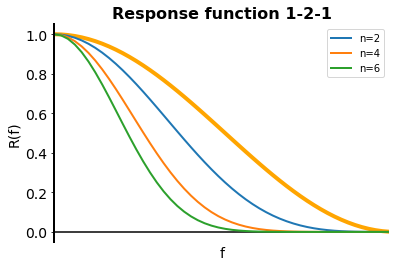

In [35]:
At = 1
f = np.arange(0,0.5,0.01)
R = (np.cos(np.pi*f*At))**2

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(f,R,linewidth=4,color='orange')
ax.plot([f.min(),f.max()],[0,0],color='k')
#ax.grid()
ax.set_xlim([f.min(),f.max()])
ax.set_ylabel('R(f)')
ax.set_xlabel('f')
ax.set_title('Response function 1-2-1',fontsize=16,weight='bold')
ax.set_xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Si aplicamos n veces el filtro
for n in [2, 4, 6]:
    Rn = R**n
    ax.plot(f,Rn,linewidth=2,label='n='+str(n))
ax.legend()

#### Para construir un filtro pasa-alto a partir de 1-2-1 usamos la propiedad lineal de la transformada de Fourier

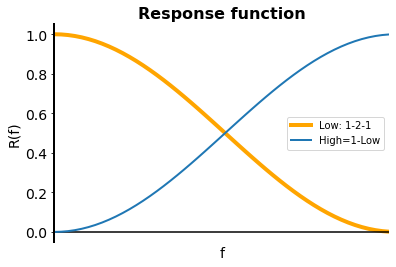

In [36]:
At = 1
f = np.arange(0,0.5,0.01)
R = (np.cos(np.pi*f*At))**2

fig, ax = plt.subplots(1,1,figsize=(6,4))
ax.plot(f,R,linewidth=4,color='orange',label='Low: 1-2-1')
ax.plot([f.min(),f.max()],[0,0],color='k')
#ax.grid()
ax.set_xlim([f.min(),f.max()])
ax.set_ylabel('R(f)')
ax.set_xlabel('f')
ax.set_title('Response function',fontsize=16,weight='bold')
ax.set_xticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#Si buscamos el filtro pasa alta
ax.plot(f,1-R,linewidth=2,label='High=1-Low')
ax.legend()

## Un filtro empleado con frecuencia es el de Butterworth
### Se trata de un filtro recursivo que depende de dos características:
+ ### Número de orden del filtro (n)
+ ### Frecuencia de corte del filtro ($f_c$)


### Su función de respuesta es:
> ### $|R(f)|^2 = \frac{1}{1+\left ( \frac{f}{f_c}\right ) ^{2 n}}$


### Veamos cómo diseñarlo, evaluar su función de respuesta (qué hace con el contenido espectral de la señal) y de impulso (hasta dónde afecta los bordes)

Text(0.5, 0.98, 'Butterworth filter')

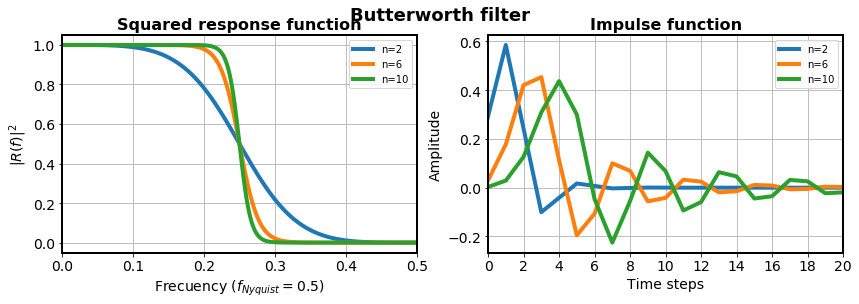

In [37]:
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(14,4))

# Diseñamos un impulso:
imp = signal.unit_impulse(100,'mid')
timesteps = np.arange(-50,50)
#ax2.plot(timesteps,imp)

# Escogemos orden n (nos dará n+1 coefs de b y otros tantos para a) y frecuencia de corte del filtro.
# ATENCIÓN a la fecuencia de corte que tiene que estar en unidades de la frecuencia de Nyquist (la máxima)
# Esto implica que 0 <= fc <= 1
# Vamos a usarlo para hacer un pasa-baja, pero se puede diseñar cualquiera de los otros 3 tipos de filtros
# Mirad la ayuda si queréis hacer un pasa-banda o para-banda. Para pasa-alta, podéis usar la 
# propiedad lineal de los filtros de modo que high=signal - low, donde signal es la señal original, y low la filtrada
# pasa-baja
# Le vamos a pedir como output los coefs b y a (opición : output='ba')
fc = 0.5
for n in [2, 6, 10]:
    b, a = signal.butter(n,fc,output='ba')
    # Lo aplicamos al impulso:
    resp = signal.lfilter(b,a,imp)
    # Para evaluar la función de respuesta del filtro se puede emplear la función freqz de signal:
    w, h = signal.freqz(b,a)
    f = w / 2 / np.pi # Para recuperar la frecuencia
    # Cuidado que en esta salida de la función 0.5 es fmax (frecuencia de Nyquist). 
    ## Como arriba pusimos fc=0.5, en una representación donde fmax es 0.5, implica fc=0.5*0.5=0.25, que es donde 
    ## veremos la mitad de la potencia espectral cuando lo pintemos
    ax1.plot(f,abs(h)**2,linewidth=4,label='n='+str(n))
    ax2.plot(timesteps, resp,linewidth=4,label='n='+str(n))

ax1.set_xlim([0,0.5])
ax1.grid()
ax1.set_title('Squared response function',fontsize=16,weight='bold')
ax1.set_xlabel(r'Frecuency ($f_{Nyquist}=0.5$)')
ax1.set_ylabel(r'$|R(f)|^2$')
ax1.legend()

ax2.set_xlim([0,20])
ax2.grid()
ax2.set_title('Impulse function',fontsize=16,weight='bold')
ax2.set_xlabel('Time steps')
ax2.set_ylabel('Amplitude')
ax2.set_xticks(np.arange(0,21,2))
ax2.legend()


fig.suptitle('Butterworth filter',fontsize=18,weight='bold')



### Comprobemos las funciones de respuesta y calculemos las de impulso de los filtros media móvil y 1-2-1
### 1. Media móvil

Text(0.5, 0.98, 'Moving average filter')

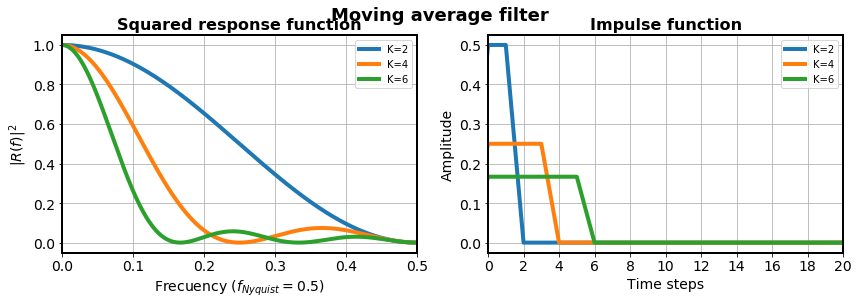

In [38]:
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(14,4))

# Diseñamos un impulso:
imp = signal.unit_impulse(100,'mid')
timesteps = np.arange(-50,50)

# Diseñamos coefs de media móvil con K coeficientes (ventana tamaño K)
for K in [2, 4, 6]:
    b = 1 / (K) * np.ones(K)
    w, h = signal.freqz(b,1)
    f = w / 2 / np.pi # Para recuperar la frecuencia
    resp = signal.lfilter(b,1,imp)
    ax1.plot(f,abs(h)**2,linewidth=4,label='K='+str(K))
    ax2.plot(timesteps, resp,linewidth=4,label='K='+str(K))

    
ax1.set_xlim([0,0.5])
ax1.grid()
ax1.set_title('Squared response function',fontsize=16,weight='bold')
ax1.set_xlabel(r'Frecuency ($f_{Nyquist}=0.5$)')
ax1.set_ylabel(r'$|R(f)|^2$')
ax1.legend()

ax2.set_xlim([0,20])
ax2.grid()
ax2.set_title('Impulse function',fontsize=16,weight='bold')
ax2.set_xlabel('Time steps')
ax2.set_ylabel('Amplitude')
ax2.set_xticks(np.arange(0,21,2))
ax2.legend()


fig.suptitle('Moving average filter',fontsize=18,weight='bold')



### 2. Filtro 1-2-1


Text(0.5, 0.98, '1-2-1 filter')

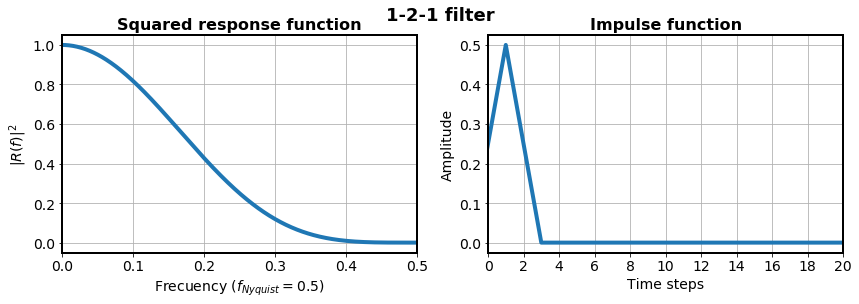

In [39]:
fig,[ax1,ax2]=plt.subplots(1,2,figsize=(14,4))

# Diseñamos un impulso:
imp = signal.unit_impulse(100,'mid')
timesteps = np.arange(-50,50)

# Diseñamos coefs de filtro 1-2-1:
b = [1/4, 1/2, 1/4]
w, h = signal.freqz(b,1)
f = w / 2 / np.pi # Para recuperar la frecuencia
resp = signal.lfilter(b,1,imp)
ax1.plot(f,abs(h)**2,linewidth=4,label='K='+str(K))
ax2.plot(timesteps, resp,linewidth=4,label='K='+str(K))

    
ax1.set_xlim([0,0.5])
ax1.grid()
ax1.set_title('Squared response function',fontsize=16,weight='bold')
ax1.set_xlabel(r'Frecuency ($f_{Nyquist}=0.5$)')
ax1.set_ylabel(r'$|R(f)|^2$')
#ax1.legend()

ax2.set_xlim([0,20])
ax2.grid()
ax2.set_title('Impulse function',fontsize=16,weight='bold')
ax2.set_xlabel('Time steps')
ax2.set_ylabel('Amplitude')
ax2.set_xticks(np.arange(0,21,2))
#ax2.legend()


fig.suptitle('1-2-1 filter',fontsize=18,weight='bold')



## Veamos qué podemos hacer en los bordes si no queremos perder datos:

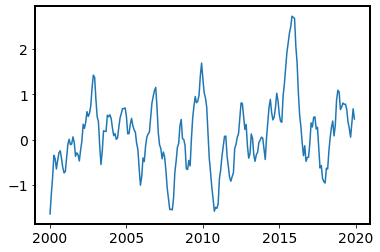

In [40]:
#Usemos los últimos 20 años de la serie de anomalías de temperaturas del Pacífico
L = -240
t = np.squeeze(np.array(time[L:]))
x = np.squeeze(np.array(anom[L:]))
N = x.size
t2 = np.zeros(2*N)
t2[0:N]=t
t2[N:]=t+(t[1]-t[0])*N
plt.plot(t,x)

### 1) Mínimo valor

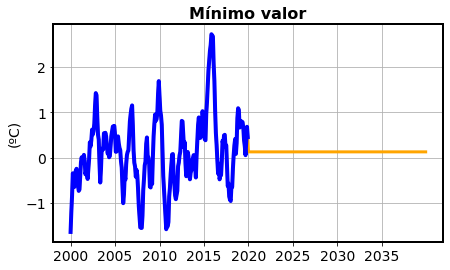

In [41]:
# 1) Condición de mínimo valor:
xm = x.mean()
xMinValor = np.zeros(2*N)
xMinValor[0:N] = x
xMinValor[N:] = xm


fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(t2,xMinValor,linewidth=3,color='orange')
ax.plot(t,x,linewidth=4,color='b')
ax.set_ylabel('(ºC)')
ax.set_xticks(np.arange(2000,2040,5))
ax.set_title('Mínimo valor',fontsize=16,weight='bold')
ax.grid()



### 2) Mínima derivada

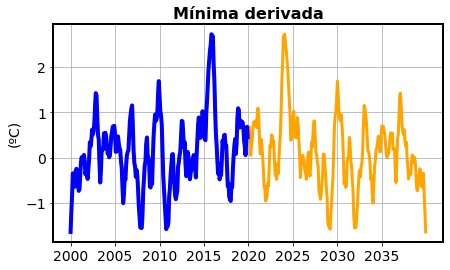

In [42]:
xm = x.mean()
xMinDeri = np.zeros(2*N)
xMinDeri[0:N] = x
xMinDeri[N:] = np.flip(x)

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(t2,xMinDeri,linewidth=3,color='orange')
ax.plot(t,x,linewidth=4,color='b')
ax.set_ylabel('(ºC)')
ax.set_xticks(np.arange(2000,2040,5))
ax.set_title('Mínima derivada',fontsize=16,weight='bold')
ax.grid()


### 3) Mínima aspereza

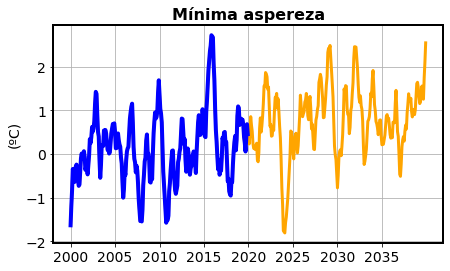

In [43]:
xm = x.mean()
xMinRough = np.zeros(2*N)
xMinRough[0:N] = x
xMinRough[N:] = 2 * x[N-1] - np.flip(x)

fig,ax = plt.subplots(1,1,figsize=(7,4))
ax.plot(t2,xMinRough,linewidth=3,color='orange')
ax.plot(t,x,linewidth=4,color='b')
ax.set_ylabel('(ºC)')
ax.set_xticks(np.arange(2000,2040,5))
ax.set_title('Mínima aspereza',fontsize=16,weight='bold')
ax.grid()


## Veamos un ejemplo de aplicación: la señal del Atlántico.
Vimos al analizar su espectro que tenía una componente de baja frecuencia. Extraigámosla de los datos mensuales. Buscamos una frecuencia de corte correspondiente a un periodo de 15 años.

#### Emplearemos los siguientes filtros
#### 1) Media móvil
#### 2) Butterworth

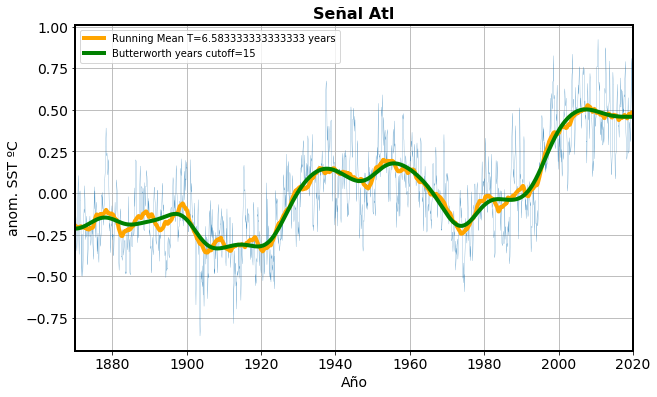

In [44]:
fig,ax = plt.subplots(1,1,figsize=(10,6))

# La señal inicial
x = np.squeeze(np.array(atl))
t = np.squeeze(np.array(time))
N = x.size
ax.plot(t,x,linewidth=0.2)


#Voy a usar la condición mínima derivada en ambos extremos:
xtot = np.append(np.flip(x),[x,np.flip(x)])

# frecuencia de corte (en meses) (15 años):
nyc = 15
Tc = nyc * 12
fc = 1 / Tc

#Media móvil: necesito una ventana de aprox. Tc/0.443
Window = int(0.443/fc)
#Window = Tc

#Filtro la señal ampliada y luego me quedo con el trozo central
ytot = runningMean(xtot,Window)
yRunningMean = ytot[N:2*N]


#Filtro de Butterworth, escogemos orden nominal 4
#Cuidado que el filtro de Butter tiene la frecuencia normalizada con 1 correspondiendo a fmax=FNyquist
n = 4
b,a = signal.butter(n,fc*2,output='ba')
#Filtro la señal ampliada y me quedo con la parte central:
ytot = signal.filtfilt(b,a,xtot)
yButter = ytot[N:2*N]


ax.grid()
ax.set_title('Señal Atl',fontsize=16,weight='bold')
ax.set_xlabel('Año')
ax.set_ylabel('anom. SST ºC')
ax.plot(t,yRunningMean,linewidth= 4,color='orange',label='Running Mean T='+str(Window/12)+' years')
ax.plot(t,yButter,linewidth= 4,color='green',label='Butterworth years cutoff='+str(nyc))
ax.set_xlim([1870,2020])
ax.legend()


### Comparemos las funciones de respuesta de Butter y de running mean en las proximidades de la frecuencia de corte

[79, 79]


Text(0, 0.5, '$|R(f)|^2$')

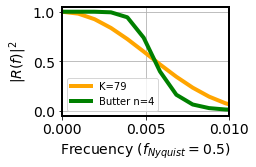

In [45]:
fig,ax=plt.subplots(1,1,figsize=(3,2))

nyc = 15
Tc = nyc * 12
fc = 1 / Tc

#Media móvil: necesito una ventana de aprox. Tc/0.443
K = int(0.443/fc)

print([Window,K])
b = 1 / (K) * np.ones(K)
w, h = signal.freqz(b,1)
f = w / 2 / np.pi # Para recuperar la frecuencia
ax.plot(f,abs(h)**2,linewidth=4,color='orange',label='K='+str(K))

n = 4
b,a = signal.butter(n,2*fc,output='ba')
w, h = signal.freqz(b,a)
f = w / 2 / np.pi # Para recuperar la frecuencia
ax.plot(f,abs(h)**2,linewidth=4,color='green',label='Butter n='+str(n))

ax.set_xlim([0,0.01])
ax.grid()
ax.legend()
ax.set_xlabel(r'Frecuency ($f_{Nyquist}=0.5$)')
ax.set_ylabel(r'$|R(f)|^2$')